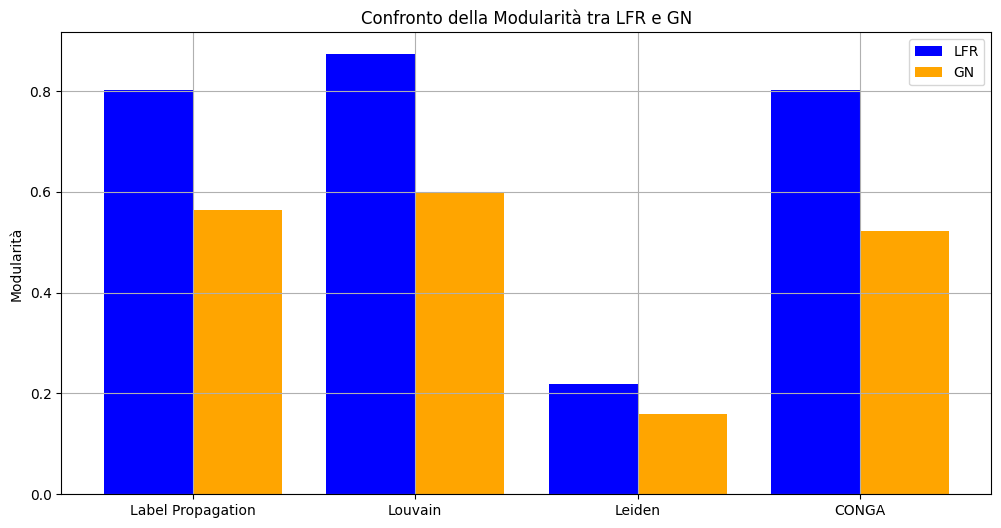

Numero di comunità nel grafo LFR: 17
Risultati per LFR:
Label Propagation: Modularità = 0.8012
+--------------+----------------------+
|  Community   |        Nodes         |
+--------------+----------------------+
| Community 1  |      [0, 9, 38]      |
| Community 2  |   [1, 24, 46, 47]    |
| Community 3  |       [2, 22]        |
| Community 4  |  [3, 5, 12, 15, 49]  |
| Community 5  | [4, 31, 37, 39, 41]  |
| Community 6  | [6, 18, 19, 20, 34]  |
| Community 7  |       [7, 35]        |
| Community 8  |   [8, 21, 29, 33]    |
| Community 9  |       [10, 32]       |
| Community 10 | [11, 16, 25, 27, 48] |
| Community 11 |     [13, 14, 26]     |
| Community 12 |   [17, 36, 40, 45]   |
| Community 13 |       [23, 30]       |
| Community 14 |         [28]         |
| Community 15 |         [42]         |
| Community 16 |         [43]         |
| Community 17 |         [44]         |
+--------------+----------------------+
Louvain: Modularità = 0.8730
+--------------+--------------------

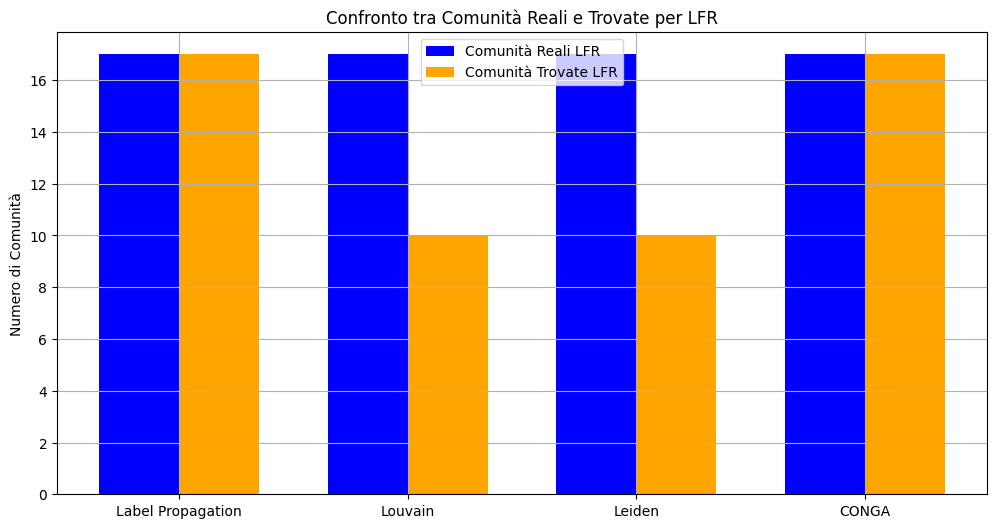

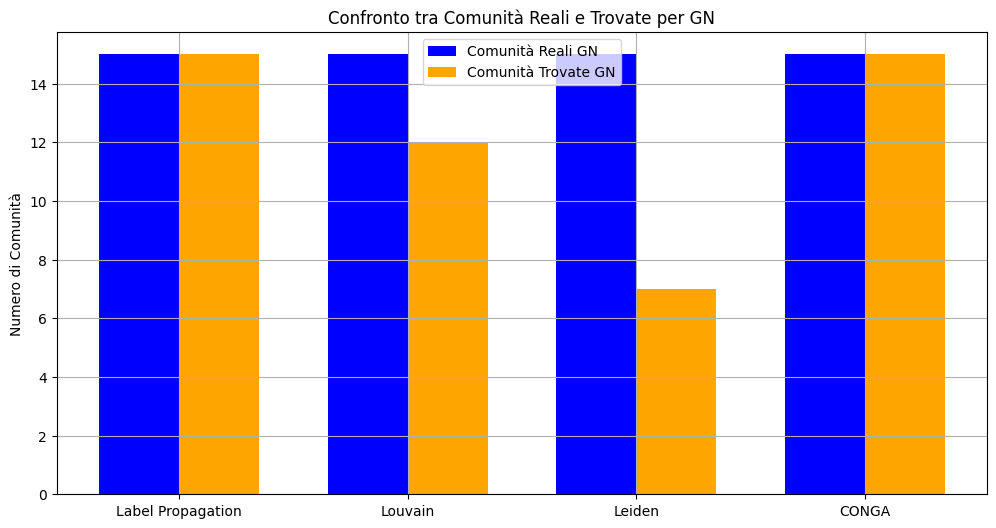

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
from cdlib import evaluation, NodeClustering
import community as community_louvain
import leidenalg as la
import igraph as ig
from cdlib import algorithms
import random
from prettytable import PrettyTable  # Importa PrettyTable per la formattazione della tabella

# Funzione per generare il benchmark LFR
def generate_lfr_graph(n, tau1, tau2, mu, min_deg, max_deg, min_comm):
    graph = nx.generators.LFR_benchmark_graph(
        n=n,
        tau1=tau1,
        tau2=tau2,
        mu=mu,
        min_degree=min_deg,
        max_degree=max_deg,
        min_community=min_comm,
        seed=42
    )
    return graph

# Funzione per generare il benchmark GN
def generate_gn_graph(n, p_in, p_out):
    graph = nx.Graph()
    num_communities = 2
    community_sizes = [n // num_communities] * num_communities

    for i in range(num_communities):
        for j in range(community_sizes[i]):
            graph.add_node(i * community_sizes[i] + j, community=i)

    for i in range(num_communities):
        for j in range(community_sizes[i]):
            for k in range(j + 1, community_sizes[i]):
                if random.random() < p_in:
                    graph.add_edge(i * community_sizes[i] + j, i * community_sizes[i] + k)

    for i in range(num_communities):
        for j in range(num_communities):
            if i != j:
                for node in range(community_sizes[i]):
                    if random.random() < p_out:
                        graph.add_edge(i * community_sizes[i] + node, j * community_sizes[j] + random.randint(0, community_sizes[j] - 1))

    return graph

# Parametri per il benchmark LFR
n_lfr = 50  # Numero di nodi per LFR
tau1, tau2 = 2, 1.5  # Esponenti per la distribuzione dei gradi
mu = 0.1  # Frazione di collegamenti tra comunità
min_deg, max_deg = 2, 5  # Gradi minimo e massimo
min_comm = 5  # Numero minimo di nodi per comunità

# Genera il grafo LFR
try:
    G_lfr = generate_lfr_graph(n_lfr, tau1, tau2, mu, min_deg, max_deg, min_comm)
except Exception as e:
    print("Errore durante la generazione del grafo LFR:", str(e))
    G_lfr = None

# Genera la partizione di comunità reale per LFR se il grafo è stato generato
if G_lfr is not None:
    true_communities_lfr = list(nx.algorithms.community.label_propagation_communities(G_lfr))
    true_communities_lfr_cdlib = NodeClustering(true_communities_lfr, graph=G_lfr)

# Parametri per il benchmark GN
n_gn = 50  # Numero di nodi per GN
p_in, p_out = 0.1, 0.01  # Probabilità di collegamento interno e esterno

# Genera il grafo GN
G_gn = generate_gn_graph(n_gn, p_in, p_out)

# Genera la partizione di comunità reale per GN
true_communities_gn = list(nx.algorithms.community.label_propagation_communities(G_gn))
true_communities_gn_cdlib = NodeClustering(true_communities_gn, graph=G_gn)

# Funzione per applicare gli algoritmi e calcolare la modularità
def apply_algorithms_and_evaluate(G, true_communities_cdlib):
    results = {}

    # Label Propagation
    communities_label_propagation = list(nx.algorithms.community.label_propagation_communities(G))
    communities_label_propagation_cdlib = NodeClustering(communities_label_propagation, graph=G)
    modularity_label_propagation = evaluation.newman_girvan_modularity(G, communities_label_propagation_cdlib).score
    results['Label Propagation'] = (communities_label_propagation, modularity_label_propagation)

    # Louvain
    partition_louvain = community_louvain.best_partition(G)
    communities_louvain = {}
    for node, community in partition_louvain.items():
        if community not in communities_louvain:
            communities_louvain[community] = []
        communities_louvain[community].append(node)
    communities_louvain_cdlib = NodeClustering(list(communities_louvain.values()), graph=G)
    modularity_louvain = evaluation.newman_girvan_modularity(G, communities_louvain_cdlib).score
    results['Louvain'] = (communities_louvain_cdlib.communities, modularity_louvain)

    # Leiden
    G_igraph = ig.Graph.TupleList(G.edges(), directed=False)
    partition_leiden = la.find_partition(G_igraph, la.ModularityVertexPartition)
    communities_leiden = NodeClustering([list(community) for community in partition_leiden], graph=G)
    modularity_leiden = evaluation.newman_girvan_modularity(G, communities_leiden).score
    results['Leiden'] = (communities_leiden.communities, modularity_leiden)

    # CONGA
    number_of_communities = len(true_communities_cdlib.communities)
    partition_conga = algorithms.conga(G, number_communities=number_of_communities)
    communities_conga_cdlib = NodeClustering(partition_conga.communities, graph=G)
    modularity_conga = evaluation.newman_girvan_modularity(G, communities_conga_cdlib).score
    results['CONGA'] = (communities_conga_cdlib.communities, modularity_conga)

    return results

# Applicazione degli algoritmi e calcolo della modularità per LFR
results_lfr = {}
if G_lfr is not None:
    results_lfr = apply_algorithms_and_evaluate(G_lfr, true_communities_lfr_cdlib)

# Applicazione degli algoritmi e calcolo della modularità per GN
results_gn = apply_algorithms_and_evaluate(G_gn, true_communities_gn_cdlib)

# Funzione per stampare i risultati
def print_results(results, title):
    print(f"Risultati per {title}:")
    for algorithm, (communities, modularity) in results.items():
        print(f"{algorithm}: Modularità = {modularity:.4f}")
        # Stampa delle comunità in formato tabellare
        table = PrettyTable()
        table.field_names = ["Community", "Nodes"]
        for i, community in enumerate(communities):
            table.add_row([f"Community {i + 1}", sorted(community)])
        print(table)

# Visualizzazione dei risultati tramite grafico a barre
def plot_results(results_lfr, results_gn):
    algorithms_names = list(results_lfr.keys())
    modularities_lfr = [mod for _, mod in results_lfr.values()] if results_lfr else []
    modularities_gn = [mod for _, mod in results_gn.values()]

    x = range(len(algorithms_names))
    plt.figure(figsize=(12, 6))

    # Grafico a barre per LFR
    if modularities_lfr:
        plt.bar(x, modularities_lfr, width=0.4, label='LFR', color='blue', align='center')

    # Grafico a barre per GN
    plt.bar([p + 0.4 for p in x], modularities_gn, width=0.4, label='GN', color='orange', align='center')

    plt.ylabel('Modularità')
    plt.title('Confronto della Modularità tra LFR e GN')
    plt.xticks([p + 0.2 for p in x], algorithms_names)
    plt.legend()
    plt.grid()
    plt.show()

# Visualizza i risultati
plot_results(results_lfr, results_gn)

if G_lfr is not None:
    num_communities_lfr = len(true_communities_lfr)
    print(f"Numero di comunità nel grafo LFR: {num_communities_lfr}")
    print_results(results_lfr, "LFR")

# Stampa dei risultati per GN
num_communities_gn = len(true_communities_gn)
print(f"Numero di comunità nel grafo GN: {num_communities_gn}")
print_results(results_gn, "GN")

# Funzione per creare un grafico a barre sulle comunità reali e quelle trovate
def plot_community_comparison(num_true_communities_lfr, results_lfr, num_true_communities_gn, results_gn):
    algorithms_names_lfr = list(results_lfr.keys())
    num_found_communities_lfr = []

    # Raccolta dei dati per LFR
    for algorithm, (communities, _) in results_lfr.items():
        num_found_communities_lfr.append(len(communities))

    # Dati per il grafico LFR
    true_communities_lfr = [num_true_communities_lfr] * len(algorithms_names_lfr)

    x_lfr = range(len(algorithms_names_lfr))
    plt.figure(figsize=(12, 6))

    # Grafico a barre per LFR
    bar_width = 0.35
    plt.bar(x_lfr, true_communities_lfr, width=bar_width, label='Comunità Reali LFR', color='blue', align='center')
    plt.bar([p + bar_width for p in x_lfr], num_found_communities_lfr, width=bar_width, label='Comunità Trovate LFR', color='orange', align='center')

    plt.ylabel('Numero di Comunità')
    plt.title('Confronto tra Comunità Reali e Trovate per LFR')
    plt.xticks([p + bar_width / 2 for p in x_lfr], algorithms_names_lfr)
    plt.legend()
    plt.grid()
    plt.show()

    # Ora per GN
    algorithms_names_gn = list(results_gn.keys())
    num_found_communities_gn = []

    # Raccolta dei dati per GN
    for algorithm, (communities, _) in results_gn.items():
        num_found_communities_gn.append(len(communities))

    # Dati per il grafico GN
    true_communities_gn = [num_true_communities_gn] * len(algorithms_names_gn)

    x_gn = range(len(algorithms_names_gn))
    plt.figure(figsize=(12, 6))

    # Grafico a barre per GN
    plt.bar(x_gn, true_communities_gn, width=bar_width, label='Comunità Reali GN', color='blue', align='center')
    plt.bar([p + bar_width for p in x_gn], num_found_communities_gn, width=bar_width, label='Comunità Trovate GN', color='orange', align='center')

    plt.ylabel('Numero di Comunità')
    plt.title('Confronto tra Comunità Reali e Trovate per GN')
    plt.xticks([p + bar_width / 2 for p in x_gn], algorithms_names_gn)
    plt.legend()
    plt.grid()
    plt.show()

# Esegui la funzione per il confronto delle comunità
if G_lfr is not None and G_gn is not None:
    plot_community_comparison(num_communities_lfr, results_lfr, num_communities_gn, results_gn)
